In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

#from tensorflow.keras import layers
#from tensorflow.keras import regularizers
#import keras_tuner as kt
import scipy.sparse as sp
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.losses import MeanAbsoluteError
from tensorflow.keras.losses import MeanAbsolutePercentageError
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_absolute_error, mean_squared_error
from mendeleev import H, F,Cl,Br,I

from sklearn.metrics import mean_absolute_error, mean_squared_error

from spektral.data import Dataset, DisjointLoader, Graph
from spektral.layers import GATConv, GlobalSumPool, GCSConv
from spektral.utils.convolution import normalized_adjacency

tf.__version__

2023-04-15 09:22:59.114898: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-15 09:22:59.149109: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-15 09:22:59.692298: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


'2.12.0'

In [2]:
# Load dataset
csv_file = '../Dataset/dataset_left.csv'
dataframe_raw = pd.read_csv(csv_file)
dataframe_raw = dataframe_raw.drop(dataframe_raw.columns[0],axis=1) # remove first column (no information there)
dataframe_raw.head()

,Pos1,Pos2,Pos3,Pos4,Pos5,Pos6,Pos7,Pos8,Pos9,Pos10,Pos11,Pos12,Pos13,Pos14,Pos15,Pos16,Nsubs,R,lambd
0,0,0,0,0,0,4,1,0,0,0,0,0,0,0,0,0,2,484.4822,350.23
1,0,4,2,0,0,0,0,0,0,0,0,0,0,0,0,0,2,774.6917,347.50
2,3,3,0,0,0,0,0,1,2,0,0,0,0,0,0,0,4,644.6140,364.11
3,1,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,630.3364,347.10
4,0,1,0,0,4,0,0,0,0,4,0,3,0,0,0,0,4,392.8587,358.78


In [3]:
dataframe = dataframe_raw.copy()

# Create a target variable
dataframe['target'] = dataframe['R']

# Create array with number of subtitutes
nsubs = []
nsubs[:] = dataframe['Nsubs']

# Drop unused features.
dataframe = dataframe.drop(columns=['R', 'lambd', 'Nsubs'])
dataframe.head()

,Pos1,Pos2,Pos3,Pos4,Pos5,Pos6,Pos7,Pos8,Pos9,Pos10,Pos11,Pos12,Pos13,Pos14,Pos15,Pos16,target
0,0,0,0,0,0,4,1,0,0,0,0,0,0,0,0,0,484.4822
1,0,4,2,0,0,0,0,0,0,0,0,0,0,0,0,0,774.6917
2,3,3,0,0,0,0,0,1,2,0,0,0,0,0,0,0,644.6140
3,1,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,630.3364
4,0,1,0,0,4,0,0,0,0,4,0,3,0,0,0,0,392.8587


1
32
140
40
40


(array([  1.,  32., 140.,  40.,  40.]),
 array([-0.5,  0.5,  1.5,  2.5,  3.5,  4.5]),
 <BarContainer object of 5 artists>)

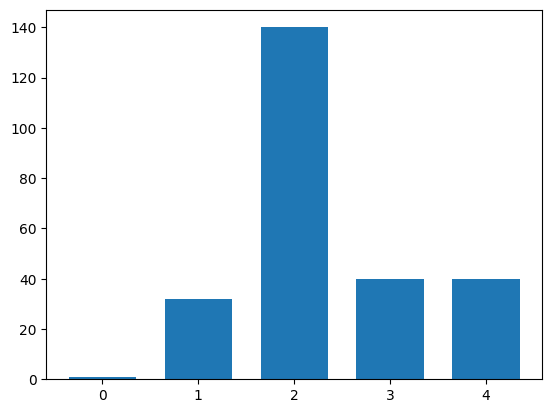

In [4]:
# number of substitutes

n0 = nsubs.count(0)
n1 = nsubs.count(1)
n2 = nsubs.count(2)
n3 = nsubs.count(3)
n4 = nsubs.count(4)
print(n0)
print(n1)
print(n2)
print(n3)
print(n4)

bin_edges = np.arange(-0.5,4.5+1,1)
plt.hist(nsubs, bins=bin_edges, rwidth=0.7)

In [5]:
# Check overal statistis of each input feature 
dataframe.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Pos1,253.0,0.664032,1.251099,0.0000,0.0000,0.0000,1.0000,4.0000
Pos2,253.0,0.774704,1.388956,0.0000,0.0000,0.0000,1.0000,4.0000
Pos3,253.0,0.632411,1.258013,0.0000,0.0000,0.0000,0.0000,4.0000
Pos4,253.0,0.557312,1.218930,0.0000,0.0000,0.0000,0.0000,4.0000
Pos5,253.0,0.513834,1.121934,0.0000,0.0000,0.0000,0.0000,4.0000
Pos6,253.0,0.430830,1.054167,0.0000,0.0000,0.0000,0.0000,4.0000
Pos7,253.0,0.383399,1.007532,0.0000,0.0000,0.0000,0.0000,4.0000
Pos8,253.0,0.533597,1.163200,0.0000,0.0000,0.0000,0.0000,4.0000
Pos9,253.0,0.332016,0.904378,0.0000,0.0000,0.0000,0.0000,4.0000
Pos10,253.0,0.284585,0.867193,0.0000,0.0000,0.0000,0.0000,4.0000


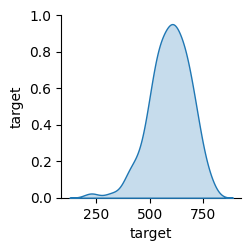

In [6]:
# Inspect the data with the joint distribition of a few pairs of columns from the training set
sns.pairplot(dataframe[['target']], diag_kind='kde')


In [7]:
""" # remove data with R~8

dataframe = dataframe[ dataframe['target']>10 ]
dataframe.describe().transpose() """

# remove data with target<Rmin
Rmin = 380
dataframe = dataframe[ dataframe['target']>Rmin ]
print(dataframe.describe().transpose())

        count        mean        std       min      25%       50%       75%   
Pos1    249.0    0.646586   1.239308    0.0000    0.000    0.0000    1.0000  \
Pos2    249.0    0.738956   1.353061    0.0000    0.000    0.0000    1.0000   
Pos3    249.0    0.614458   1.239452    0.0000    0.000    0.0000    0.0000   
Pos4    249.0    0.534137   1.187909    0.0000    0.000    0.0000    0.0000   
Pos5    249.0    0.510040   1.118439    0.0000    0.000    0.0000    0.0000   
Pos6    249.0    0.437751   1.061202    0.0000    0.000    0.0000    0.0000   
Pos7    249.0    0.389558   1.014438    0.0000    0.000    0.0000    0.0000   
Pos8    249.0    0.542169   1.170551    0.0000    0.000    0.0000    0.0000   
Pos9    249.0    0.337349   0.910651    0.0000    0.000    0.0000    0.0000   
Pos10   249.0    0.289157   0.873399    0.0000    0.000    0.0000    0.0000   
Pos11   249.0    0.212851   0.739766    0.0000    0.000    0.0000    0.0000   
Pos12   249.0    0.248996   0.834156    0.0000    0.

In [8]:
# normalize numerical targets

R_mean = dataframe['target'].mean()
R_std = dataframe['target'].std()

dataframe_norm = dataframe.copy()

dataframe_norm['target']=(dataframe['target']-R_mean)/R_std

# Check overal statistis of each input feature 
dataframe_norm.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Pos1,249.0,6.465863e-01,1.239308,0.000000,0.000000,0.000000,1.000000,4.000000
Pos2,249.0,7.389558e-01,1.353061,0.000000,0.000000,0.000000,1.000000,4.000000
Pos3,249.0,6.144578e-01,1.239452,0.000000,0.000000,0.000000,0.000000,4.000000
Pos4,249.0,5.341365e-01,1.187909,0.000000,0.000000,0.000000,0.000000,4.000000
Pos5,249.0,5.100402e-01,1.118439,0.000000,0.000000,0.000000,0.000000,4.000000
Pos6,249.0,4.377510e-01,1.061202,0.000000,0.000000,0.000000,0.000000,4.000000
Pos7,249.0,3.895582e-01,1.014438,0.000000,0.000000,0.000000,0.000000,4.000000
Pos8,249.0,5.421687e-01,1.170551,0.000000,0.000000,0.000000,0.000000,4.000000
Pos9,249.0,3.373494e-01,0.910651,0.000000,0.000000,0.000000,0.000000,4.000000
Pos10,249.0,2.891566e-01,0.873399,0.000000,0.000000,0.000000,0.000000,4.000000


In [24]:
# Load data and make graphs

data = dataframe.to_numpy()
#data = dataframe_norm.to_numpy()

class MyDataset(Dataset):

    def __init__(self, **kwargs):

        self.n_samples = data.shape[0]
        #self.num_node_features = 0
        #self.num_edge_features = 0
        #self.num_labels = 0

        super().__init__(**kwargs)

    def read(self):

        atomic_number_max = max([H.atomic_number, F.atomic_number, Cl.atomic_number, Br.atomic_number, I.atomic_number])
        atomic_radius_max = max([H.atomic_radius, F.atomic_radius, Cl.atomic_radius, Br.atomic_radius, I.atomic_radius])
        covalent_radius_max = max([H.covalent_radius, F.covalent_radius, Cl.covalent_radius, Br.covalent_radius, I.covalent_radius])
        vdw_radius_max = max([H.vdw_radius, F.vdw_radius, Cl.vdw_radius, Br.vdw_radius, I.vdw_radius])
        dipole_polarizability_max = max([H.dipole_polarizability, F.dipole_polarizability, Cl.dipole_polarizability, Br.dipole_polarizability, I.dipole_polarizability])
        electron_affinity_max = max([H.electron_affinity, F.electron_affinity, Cl.electron_affinity, Br.electron_affinity, I.electron_affinity])
        en_pauling_max = max([H.en_pauling, F.en_pauling, Cl.en_pauling, Br.en_pauling, I.en_pauling])

        def make_graph(isample):
            n_nodes = 16
            n_node_features = 7
            #n_node_features = 1
            n_labels = 1
            #self.num_node_features = n_node_features
            #self.num_labels = n_labels
            x = np.zeros((n_nodes,n_node_features))

            # node features
            for inode in range(n_nodes):
                id_at = data[isample,inode]
                """ x[inode,0] = id_at
                if(n_node_features>1):
                    atomic_properties = np.zeros( n_node_features-1 )

                    if(id_at==0): atomic_properties = [ H.atomic_number, H.atomic_radius, H.electron_affinity ]
                    if(id_at==1): atomic_properties = [ F.atomic_number, F.atomic_radius, F.electron_affinity ]
                    if(id_at==2): atomic_properties = [ Cl.atomic_number, Cl.atomic_radius, Cl.electron_affinity ]
                    if(id_at==3): atomic_properties = [ Br.atomic_number, Br.atomic_radius, Br.electron_affinity ]
                    if(id_at==4): atomic_properties = [ I.atomic_number, I.atomic_radius, I.electron_affinity ]
                    
                    x[inode,1:] = atomic_properties[:] """
                
                atomic_properties = np.zeros( n_node_features )

                if(id_at==0): atomic_properties = [ H.atomic_number, H.atomic_radius, H.covalent_radius, H.vdw_radius, H.dipole_polarizability, H.electron_affinity, H.en_pauling ]
                if(id_at==1): atomic_properties = [ F.atomic_number, F.atomic_radius, F.covalent_radius, F.vdw_radius, F.dipole_polarizability, F.electron_affinity, F.en_pauling ]
                if(id_at==2): atomic_properties = [ Cl.atomic_number, Cl.atomic_radius, Cl.covalent_radius, Cl.vdw_radius, Cl.dipole_polarizability, Cl.electron_affinity, Cl.en_pauling ]
                if(id_at==3): atomic_properties = [ Br.atomic_number, Br.atomic_radius, Br.covalent_radius, Br.vdw_radius, Br.dipole_polarizability, Br.electron_affinity, Br.en_pauling ]
                if(id_at==4): atomic_properties = [ I.atomic_number, I.atomic_radius, I.covalent_radius, I.vdw_radius, I.dipole_polarizability, I.electron_affinity, I.en_pauling ]
                   
                x[inode,:] = atomic_properties[:]
                #x[inode,0] = atomic_properties[0]
                #x[inode,:] = x[inode,:] /[ atomic_number_max, atomic_radius_max, covalent_radius_max, vdw_radius_max, dipole_polarizability_max, electron_affinity_max, en_pauling_max ]
                #print(x[inode,:])
            # binary adjacency matrix (only adjacent subtituents are connected) 
            a = np.zeros( (n_nodes, n_nodes) )
            for inode in range(n_nodes-1):
                a[inode,inode+1] = 1
            a = np.maximum(a, a.T)#.astype(int) # Adjacency matrix is symetric in this case
            a = sp.csr_matrix(a)
            a = normalized_adjacency(a, symmetric=True)

            # edge features

            # labels
            Rmax = data[isample,16]
            y = np.zeros(n_labels,)
            y[0,] = Rmax

            print(str(isample)+", Rmax: "+str(y[0,]))

            return Graph(x=x, a=a, y=y)
    
        # We must return a list of Graph objects
        return [make_graph(isample) for isample in range(self.n_samples)]  

dataset = MyDataset( )

0, Rmax: 484.4822
1, Rmax: 774.6917
2, Rmax: 644.614
3, Rmax: 630.3364
4, Rmax: 392.8587
5, Rmax: 404.2231
6, Rmax: 698.8705
7, Rmax: 668.6168
8, Rmax: 722.1028
9, Rmax: 676.0763
10, Rmax: 511.0118
11, Rmax: 670.7866
12, Rmax: 604.6825
13, Rmax: 709.4934
14, Rmax: 532.7661
15, Rmax: 781.6228
16, Rmax: 571.8015
17, Rmax: 641.2333
18, Rmax: 742.2276
19, Rmax: 554.742
20, Rmax: 667.3871
21, Rmax: 618.7054
22, Rmax: 537.8497
23, Rmax: 567.7237
24, Rmax: 583.3478
25, Rmax: 590.6174
26, Rmax: 509.9671
27, Rmax: 547.925
28, Rmax: 652.5501
29, Rmax: 543.9089
30, Rmax: 706.2611
31, Rmax: 489.8941
32, Rmax: 607.2171
33, Rmax: 680.4316
34, Rmax: 533.7604
35, Rmax: 639.1159
36, Rmax: 655.8208
37, Rmax: 494.5583
38, Rmax: 611.754
39, Rmax: 544.8066
40, Rmax: 694.2488
41, Rmax: 519.1238
42, Rmax: 524.2032
43, Rmax: 662.1677
44, Rmax: 698.5759
45, Rmax: 666.9283
46, Rmax: 544.1287
47, Rmax: 484.8454
48, Rmax: 613.3562
49, Rmax: 637.6043
50, Rmax: 492.0714
51, Rmax: 422.3459
52, Rmax: 583.7159
53, Rma

In [53]:
# Set up
learning_rate = 1e-3  # Learning rate
#learning_rate = 1e-4  # Learning rate
#epochs = 200  # Number of training epochs
#epochs = 400  # Number of training epochs
#epochs = 400  # Number of training epochs
#epochs = 1000  # Number of training epochs
#epochs = 2000  # Number of training epochs
epochs = 3000  # Number of training epochs
#epochs = 500  # Number of training epochs
#batch_size = 4  # Batch size
batch_size = 8  # Batch size

initial_learning_rate = 1e-3
#learning_rate = tf.keras.optimizers.schedules.InverseTimeDecay(initial_learning_rate=initial_learning_rate, decay_steps=epochs/10, decay_rate=0.8)
learning_rate = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=initial_learning_rate,
#                decay_steps=10, decay_rate=0.98)
                decay_steps=epochs/5, decay_rate=0.99)


""" learning_rate = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=learning_rate_initial,
    decay_steps=epochs,
    decay_rate=0.98) """

# Parameters
#F = dataset.num_node_features  # Dimension of node features
#S = dataset.num_edge_features  # Dimension of edge features
#n_out = dataset.num_labels  # Dimension of the target

# Train/test split
idxs = np.random.permutation(len(dataset))
split = int(0.8 * len(dataset))
idx_tr, idx_te = np.split(idxs, [split])
dataset_tr, dataset_te = dataset[idx_tr], dataset[idx_te]

loader_tr = DisjointLoader(dataset_tr, batch_size=batch_size, epochs=epochs)
loader_tr_eval = DisjointLoader(dataset_tr, batch_size=batch_size, epochs=1)
#loader_tr = DisjointLoader(dataset_tr, batch_size=batch_size)
loader_te = DisjointLoader(dataset_te, batch_size=batch_size, epochs=1)
#loader_te = DisjointLoader(dataset_te, batch_size=batch_size)
# we set epochs=epochs within loader_te to check loss on test set
#loader_te = DisjointLoader(dataset_te, batch_size=batch_size, epochs=epochs+1)

In [54]:
# Build model

class Net(Model):
    def __init__(self):
        super().__init__()
        #self.conv1 = ECCConv(32, activation="relu")
        #self.conv2 = ECCConv(32, activation="relu")
        self.conv1 = GCSConv(32, activation="relu")
        self.conv2 = GCSConv(32, activation="relu")
        #self.conv1 = GCSConv(64, activation="tanh")
        #self.conv2 = GCSConv(64, activation="tanh")
        #self.conv3 = GCSConv(64, activation="tanh")
        #self.conv1 = CrystalConv(aggregate="sum",activation="sigmoid")
        #self.conv2 = CrystalConv(aggregate="sum",activation="sigmoid")
        #self.conv1 = GATConv(8,attn_heads=7,dropout_rate=0,activation="relu")
        #self.conv2 = GATConv(8,attn_heads=7,dropout_rate=0,activation="relu")
        ###self.conv3 = GATConv(8,attn_heads=7,dropout_rate=0,activation="relu")
        ###self.conv4 = GATConv(8,attn_heads=7,dropout_rate=0,activation="relu")
        #self.conv1 = GATConv(4,attn_heads=3,dropout_rate=0,activation="relu")
        #self.conv2 = GATConv(4,attn_heads=3,dropout_rate=0,activation="relu")
        #self.conv3 = GATConv(8,attn_heads=7,dropout_rate=0,activation="relu")
        #self.conv4 = GATConv(8,attn_heads=7,dropout_rate=0,activation="relu")
        #self.conv1 = GATConv(16,attn_heads=8,dropout_rate=0)
        #self.conv2 = GATConv(16,attn_heads=8,dropout_rate=0)
        #self.conv3 = GATConv(16,attn_heads=8,dropout_rate=0)
        self.global_pool = GlobalSumPool()
        self.dense1 = Dense(128,activation="relu")
        self.dense2 = Dense(128,activation="relu")
        #self.dense1 = Dense(64,activation="relu")
        #self.dense2 = Dense(64,activation="relu")
        #self.dense3 = Dense(32,activation="relu")
        #self.dense1 = Dense(128)
        #self.dense2 = Dense(128)
        #self.dense3 = Dense(128)
        #self.dense = Dense(n_out,activation="sigmoid")
        self.dense = Dense(1)

    def call(self, inputs):
        #x, a, e, i = inputs
        #x = self.conv1([x, a, e])
        #x = self.conv2([x, a, e])
        x, a, i = inputs
        x = self.conv1([x, a])
        x = self.conv2([x, a])
        ###x = self.conv3([x, a])
        ###x = self.conv4([x, a])
        #x = self.conv3([x, a])
        #x = self.conv3([x, a])
        output = self.global_pool([x, i])
        output = self.dense1(output)
        output = self.dense2(output)
        #output = self.dense3(output)
        #output = self.dense3(output)
        #output = self.dense(output)
        #output = self.dense3(x)
        output = self.dense(output)

        return output

model = Net()
optimizer = Adam(learning_rate)
#loss_fn = MeanSquaredError()
loss_fn = MeanAbsoluteError()
#loss_fn = MeanAbsolutePercentageError()

/home/alfonso/Work/UGR/Calculations/Helicenes_NNs/Helicenes_GNNs_venv/lib/python3.10/site-packages/spektral/data/utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)
/home/alfonso/Work/UGR/Calculations/Helicenes_NNs/Helicenes_GNNs_venv/lib/python3.10/site-packages/keras/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(
2023-04-15 09:51:07.716289: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an erro

1 Loss: 117.78495025634766
2 Loss: 72.70735168457031
3 Loss: 76.98882293701172
4 Loss: 85.54322052001953
5 Loss: 71.87507629394531
6 Loss: 83.85730743408203
7 Loss: 79.95513916015625
8 Loss: 76.6548080444336
9 Loss: 72.09536743164062
10 Loss: 71.31454467773438
11 Loss: 71.0413818359375
12 Loss: 72.8862075805664
13 Loss: 82.78515625
14 Loss: 86.60917663574219
15 Loss: 71.48464965820312
16 Loss: 74.29583740234375
17 Loss: 70.45823669433594
18 Loss: 70.31702423095703
19 Loss: 74.20565795898438
20 Loss: 70.3583755493164
21 Loss: 69.32389831542969
22 Loss: 72.45283508300781
23 Loss: 75.2911148071289
24 Loss: 70.24772644042969
25 Loss: 80.53910827636719
26 Loss: 69.53355407714844
27 Loss: 74.03311157226562
28 Loss: 71.79808044433594
29 Loss: 71.86267852783203
30 Loss: 71.27392578125
31 Loss: 69.24650573730469
32 Loss: 75.56114959716797
33 Loss: 77.77125549316406
34 Loss: 70.64716339111328
35 Loss: 70.82963562011719
36 Loss: 72.78307342529297
37 Loss: 68.08397674560547
38 Loss: 68.96917724609

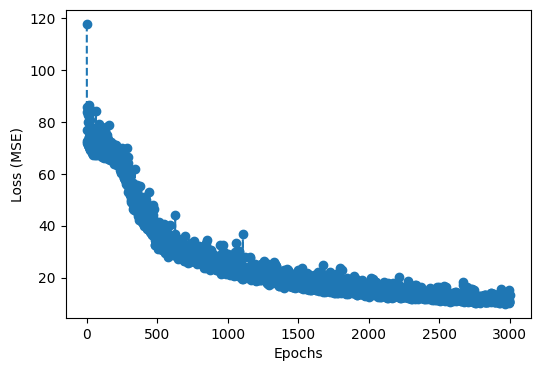

'\n# Plot Loss Function on Test Set\nplt.figure(figsize=(6,4))\nplt.scatter(range(1,epochs+1),loss_test)\nplt.plot(range(1,epochs+1),loss_test,ls="--")\nplt.xlabel("Epochs")\nplt.ylabel("Loss (MSE)")\nplt.show()\n'

In [55]:
# Fit model

################################################################################
# Fit model
################################################################################
@tf.function(input_signature=loader_tr.tf_signature(), experimental_relax_shapes=True)
def train_step(inputs, target):
    with tf.GradientTape() as tape:
        predictions = model(inputs, training=True)
        loss = loss_fn(target, predictions) + sum(model.losses)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

outfile = open("loss.dat",'w')
nepoch = 1
step = loss = 0
loss_train = []
#loss_test = []
#loss_te = 0
for batch in loader_tr:
    step += 1
    loss += train_step(*batch)
    if step == loader_tr.steps_per_epoch:
        step = 0
        print(str(nepoch)+" Loss: {}".format(loss / loader_tr.steps_per_epoch))
        outfile.write(str(nepoch)+" {}".format(loss / loader_tr.steps_per_epoch)+" \n")
        loss_train.append(loss / loader_tr.steps_per_epoch)

        #if(nepoch==epochs): break
        nepoch = nepoch + 1

        # log the loss into wandb
        #wandb.log({"loss": loss / loader_tr.steps_per_epoch})
        
        loss = 0

        """
        # Loss on test set
        batch_te = next(iter(loader_te))
        inputs, target = batch_te
        predictions = model(inputs, training=False)
        #loss_te += loss_fn(target, predictions)
        loss_te = loss_fn(target, predictions)
        #loss_te /= loader_te.steps_per_epoch
        loss_test.append(loss_te)
        #loss_te = 0
        """

outfile.close()

# Plot Loss Function on Training Set
plt.figure(figsize=(6,4))
plt.scatter(range(1,epochs+1),loss_train)
plt.plot(range(1,epochs+1),loss_train,ls="--")
plt.xlabel("Epochs")
plt.ylabel("Loss (MSE)")
plt.show()

"""
# Plot Loss Function on Test Set
plt.figure(figsize=(6,4))
plt.scatter(range(1,epochs+1),loss_test)
plt.plot(range(1,epochs+1),loss_test,ls="--")
plt.xlabel("Epochs")
plt.ylabel("Loss (MSE)")
plt.show()
"""

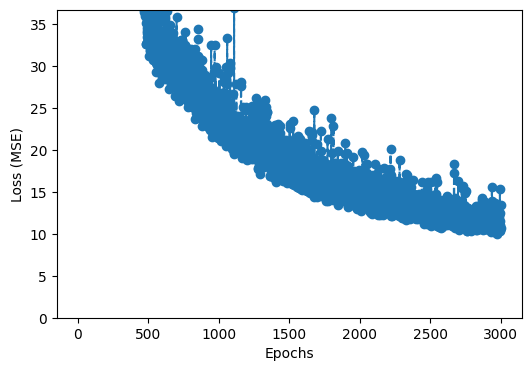

In [56]:
# Plot Loss Function on Training Set
plt.figure(figsize=(6,4))
plt.scatter(range(1,epochs+1),loss_train)
plt.plot(range(1,epochs+1),loss_train,ls="--")
plt.xlabel("Epochs")
plt.ylabel("Loss (MSE)")
ymedian = np.median(loss_train)
#plt.xlim(0,200)
plt.ylim(0,ymedian*2)
plt.show()

Testing model
Done. Test loss: 43.11056900024414


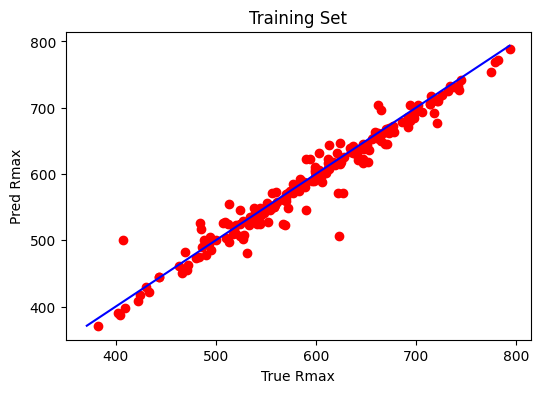

Test MAE: 12.08423342420108
Test MSE: 353.43820223801106
Test MAPE: 2.101181714399029


In [57]:
# Evaluate model on train set

# Loss on Test Set. Predicted vs Real energies
print("Testing model")
loss = 0
ypred = []
ytrue = []
for batch in loader_tr_eval:
    inputs, target = batch
    predictions = model(inputs, training=False)
    loss += loss_fn(target, predictions)
    ypred.append(predictions)
    ytrue.append(target)
    #break
loss /= loader_te.steps_per_epoch
print("Done. Test loss: {}".format(loss))

n_batches = len(ypred)
y_pred = np.zeros(n_batches*batch_size)
y_true = np.zeros(n_batches*batch_size)
for ibatch in range(n_batches):
    #print(np.array(ypred[ibatch]))
    #print(np.array(ypred[ibatch]).ravel())
    imin = ibatch*batch_size
    imax = imin + batch_size
    #if (ibatch==n_batches-1): imax=imin+2
    y_pred_aux = np.array(ypred[ibatch]).ravel()
    imax = imin + len(y_pred_aux)
    y_pred[imin:imax] = np.array(ypred[ibatch]).ravel()
    y_true[imin:imax] = np.array(ytrue[ibatch]).ravel()
    #print(y_pred[imin:imax])

#print(y_pred)
#y_true = np.array(ytrue).ravel()
#print(y_true)
#print(ytrue)

# Remove zero elements 
y_pred = y_pred[ y_true!=0.0 ]
y_true = y_true[ y_true!=0.0 ]

plt.figure(figsize=(6,4))
plt.scatter(y_true,y_pred,label = "GNN model",color="red")
p1 = max(max(y_pred), max(y_true))
p2 = min(min(y_pred), min(y_true))
plt.plot([p1, p2], [p1, p2], 'b-')
#plt.plot(np.linspace(-0.2,0.1,50),np.linspace(-0.2,0.1,50))
plt.xlabel("True Rmax")
plt.ylabel("Pred Rmax")
#plt.xlim(-5,0)
#plt.ylim(-5,0)
plt.title("Training Set")
plt.show()

# mean absolute percentage error (MAPE)
def mape(ytrue, ypred):
    ytrue, ypred = np.array(ytrue), np.array(ypred)
    
    mape_i = np.zeros(len(ytrue))
    mape_i = np.abs((ypred-ytrue)/ytrue)*100
    mape_i = mape_i[ mape_i < 1e3]

    return np.mean(mape_i)

# Compute metrics (MAPE, MAE, MSE)
print("Test MAE:", mean_absolute_error(y_true,y_pred))
print("Test MSE:", mean_squared_error(y_true,y_pred))
print("Test MAPE:", mape(y_true,y_pred))



In [58]:
################################################################################
# Evaluate model
################################################################################

# Loss on Test Set. Predicted vs Real energies
print("Testing model")
loss = 0
ypred = []
ytrue = []
for batch in loader_te:
    inputs, target = batch
    predictions = model(inputs, training=False)
    loss += loss_fn(target, predictions)
    ypred.append(predictions)
    ytrue.append(target)
    #break
loss /= loader_te.steps_per_epoch
print("Done. Test loss: {}".format(loss))

Testing model
Done. Test loss: 39.43017578125


/home/alfonso/Work/UGR/Calculations/Helicenes_NNs/Helicenes_GNNs_venv/lib/python3.10/site-packages/spektral/data/utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


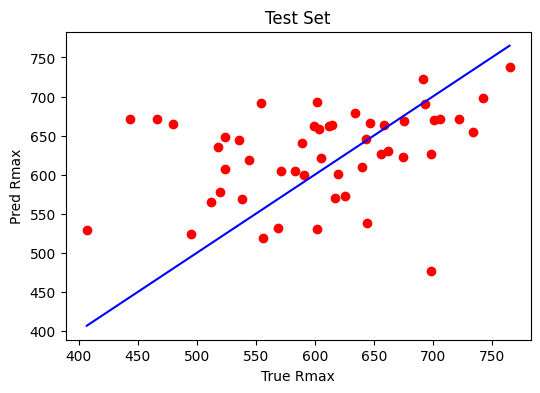

Test MAE: 63.77964967668258
Test MSE: 7017.094896204262
Test MAPE: 11.408106797194575


In [17]:
# Plot Predicted vs Real on Test Set (Original Units)

y_true = y_true * R_std + R_mean
y_pred = y_pred * R_std + R_mean

plt.figure(figsize=(6,4))
plt.scatter(y_true,y_pred,label = "GNN model",color="red")
p1 = max(max(y_pred), max(y_true))
p2 = min(min(y_pred), min(y_true))
plt.plot([p1, p2], [p1, p2], 'b-')
#plt.plot(np.linspace(-0.2,0.1,50),np.linspace(-0.2,0.1,50))
plt.xlabel("True Rmax")
plt.ylabel("Pred Rmax")
#plt.xlim(-5,0)
#plt.ylim(-5,0)
plt.title("Test Set")
plt.show()

# mean absolute percentage error (MAPE)
def mape(ytrue, ypred):
    ytrue, ypred = np.array(ytrue), np.array(ypred)
    
    mape_i = np.zeros(len(ytrue))
    mape_i = np.abs((ypred-ytrue)/ytrue)*100
    mape_i = mape_i[ mape_i < 1e3]

    return np.mean(mape_i)

# Compute metrics (MAPE, MAE, MSE)
print("Test MAE:", mean_absolute_error(y_true,y_pred))
print("Test MSE:", mean_squared_error(y_true,y_pred))
print("Test MAPE:", mape(y_true,y_pred))

In [7]:
# normalize numerical targets

R_mean = dataframe['target'].mean()
R_std = dataframe['target'].std()

dataset = dataframe.copy()

dataset['target']=(dataset['target']-R_mean)/R_std

# Check overal statistis of each input feature 
dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Pos1,249.0,6.465863e-01,1.239308,0.000000,0.000000,0.000000,1.000000,4.000000
Pos2,249.0,7.389558e-01,1.353061,0.000000,0.000000,0.000000,1.000000,4.000000
Pos3,249.0,6.144578e-01,1.239452,0.000000,0.000000,0.000000,0.000000,4.000000
Pos4,249.0,5.341365e-01,1.187909,0.000000,0.000000,0.000000,0.000000,4.000000
Pos5,249.0,5.100402e-01,1.118439,0.000000,0.000000,0.000000,0.000000,4.000000
Pos6,249.0,4.377510e-01,1.061202,0.000000,0.000000,0.000000,0.000000,4.000000
Pos7,249.0,3.895582e-01,1.014438,0.000000,0.000000,0.000000,0.000000,4.000000
Pos8,249.0,5.421687e-01,1.170551,0.000000,0.000000,0.000000,0.000000,4.000000
Pos9,249.0,3.373494e-01,0.910651,0.000000,0.000000,0.000000,0.000000,4.000000
Pos10,249.0,2.891566e-01,0.873399,0.000000,0.000000,0.000000,0.000000,4.000000


In [9]:
# Shuffle the dataset
dataset = dataset.sample(frac=1,random_state=39).reset_index(drop=True)

# Split the dataframe into training, validation, and test sets
train_ds = dataset.sample(frac=0.8, random_state=10)
test_ds = dataset.drop(train_ds.index)
print(len(train_ds), 'training examples')
print(len(test_ds), 'test and validation examples')

# split features and labels/targets
train_features = train_ds.copy()
test_features = test_ds.copy()

train_labels = train_features.pop('target')
test_labels = test_features.pop('target')
print(train_features.shape)
print(train_labels.shape)


199 training examples
50 test and validation examples
(199, 16)
(199,)


In [ ]:
# Create the model architecture

""" n_features = train_features.shape[1]
input = tf.keras.Input(shape=(n_features,))
model = tf.keras.Sequential()
model.add(input) """

# tiny model
#x = tf.keras.layers.Dense(8, activation="relu")(all_features)

# small model 
#x = tf.keras.layers.Dense(16, activation="relu")(all_features)
#x = tf.keras.layers.Dense(16, activation="relu")(x)

# medium model
""" model.add(tf.keras.layers.Dense(64, activation="relu"))
model.add(tf.keras.layers.Dense(64, activation="relu"))
model.add(tf.keras.layers.Dense(64, activation="relu")) """

# large model
#x = tf.keras.layers.Dense(512, activation="relu")(all_features)
#x = tf.keras.layers.Dense(512, activation="relu")(x)
#x = tf.keras.layers.Dense(512, activation="relu")(x)
#x = tf.keras.layers.Dense(512, activation="relu")(x)

# large model with L2-regularization and dropout
""" x = tf.keras.layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001), activation="relu")(all_features)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001), activation="relu")(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001), activation="relu")(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001), activation="relu")(x)
x = tf.keras.layers.Dropout(0.5)(x) """

""" #x = tf.keras.layers.Dense(10)(x)
#output = tf.keras.layers.Dense(1)(x)
model.add(tf.keras.layers.Dense(1))

#model = tf.keras.Model(all_inputs, output)
model.summary()

#loss='mean_absolute_error',optimizer=tf.keras.optimizers.Adam(0.001)
# compile the model
model.compile(#optimizer='adam',
              #loss='mean_absolute_error',
              #loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              loss=tf.keras.losses.MeanAbsoluteError(),
              optimizer=tf.keras.optimizers.Adam(0.0001)
              #optimizer=tf.keras.optimizers.Adam(0.001),
              #metrics=["accuracy"])
)

tf.keras.utils.plot_model(model, show_shapes=True, rankdir="LR") """

In [10]:
# Define the hypermodel to optimize hyperparameters

def model_builder(hp):
  
  n_features = train_features.shape[1]
  input = tf.keras.Input(shape=(n_features,))
  model = tf.keras.Sequential()
  model.add(input)

  # Tune the number of units in the Dense layers
  # Choose an optimal value between 8-128
  hp_units = hp.Int('units', min_value=8, max_value=128, step=2, sampling='log')
  
  # Tune the number of layers between 1-4
  #hp_layers = hp.Int('layers', min_value=1, max_value=4, step=1)
  #hp_layers = hp.Int('layers', min_value=1, max_value=4, step=1, sampling='linear')
  hp_layers = hp.Int('layers', min_value=1, max_value=4, step=2, sampling='log')

  # Tune activation function between relu, tanh and sigmoid
  #hp_activation = hp.Choice('activation', values=['relu','tanh','sigmoid'])
  hp_activation = hp.Choice('activation', values=['relu','tanh'])

  # Define architecture
  for i in range(hp_layers):
    #model.add(keras.layers.Dense(units=hp_units, activation='tanh'))
    model.add(tf.keras.layers.Dense(units=hp_units, activation=hp_activation))
  model.add(tf.keras.layers.Dense(1))

  # Tune the learning rate for the optimizer
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

  # Tune the batch size
  #hp_batch = hp.Int('batch', min_value=32, max_value=256, step=2, sampling='log')

  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss='mean_absolute_error')   

  return model

In [11]:
# Instantiate the tuner and perform hypertuning

tuner = kt.Hyperband(model_builder,
                     #objective='val_accuracy',
                     objective='val_loss',
                     #max_epochs=10,
                     max_epochs=100,
                     factor=3,
                     #factor=2,
                     directory='./Hypertuning',
                     project_name='hypertuning_left_IntEnc_explore')

2023-04-14 14:20:17.649386: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-14 14:20:17.673633: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2023-04-14 14:20:17.673660: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2023-04-14 14:20:17.674079: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neur

In [13]:
# Create a callback to stop training early after reaching a certain value for the validation loss.
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

# search() method receives same arguments as fit() method, plus callbacks
# if batch_size is not specified, 32 is the default value
batch_size = 4
tuner.search(train_features, train_labels, epochs=100, validation_split=0.1, batch_size=batch_size, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete! The optimal number of layers, number of units, 
learning rate and activation function are:
n_layers: {best_hps.get('layers')}
n_units: {best_hps.get('units')}
learning_rate: {best_hps.get('learning_rate')}
activation_function: {best_hps.get('activation')}
""")

Trial 90 Complete [00h 00m 01s]
val_loss: 0.6126095652580261

Best val_loss So Far: 0.4469328820705414
Total elapsed time: 00h 02m 17s
INFO:tensorflow:Oracle triggered exit

The hyperparameter search is complete! The optimal number of layers, number of units, 
learning rate and activation function are:
n_layers: 1
n_units: 32
learning_rate: 0.01
activation_function: relu



In [14]:
# Train the model with optimal hyperparameters

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=10, min_lr=1e-6)

# Build the model with the optimal hyperparameters and train it on the data for 500 epochs
model = tuner.hypermodel.build(best_hps)
history = model.fit(train_features, train_labels, epochs=150, batch_size=batch_size
, validation_split=0.1, callbacks=[reduce_lr], verbose=2)

Epoch 1/150
45/45 - 0s - loss: 0.7649 - val_loss: 0.6731 - lr: 0.0100 - 287ms/epoch - 6ms/step
Epoch 2/150
45/45 - 0s - loss: 0.5899 - val_loss: 0.5428 - lr: 0.0100 - 36ms/epoch - 808us/step
Epoch 3/150
45/45 - 0s - loss: 0.4735 - val_loss: 0.3932 - lr: 0.0100 - 33ms/epoch - 739us/step
Epoch 4/150
45/45 - 0s - loss: 0.4069 - val_loss: 0.4429 - lr: 0.0100 - 32ms/epoch - 706us/step
Epoch 5/150
45/45 - 0s - loss: 0.3869 - val_loss: 0.4743 - lr: 0.0100 - 33ms/epoch - 728us/step
Epoch 6/150
45/45 - 0s - loss: 0.3891 - val_loss: 0.3710 - lr: 0.0100 - 34ms/epoch - 764us/step
Epoch 7/150
45/45 - 0s - loss: 0.3655 - val_loss: 0.4609 - lr: 0.0100 - 34ms/epoch - 754us/step
Epoch 8/150
45/45 - 0s - loss: 0.3958 - val_loss: 0.3533 - lr: 0.0100 - 33ms/epoch - 744us/step
Epoch 9/150
45/45 - 0s - loss: 0.3607 - val_loss: 0.2662 - lr: 0.0100 - 34ms/epoch - 746us/step
Epoch 10/150
45/45 - 0s - loss: 0.2989 - val_loss: 0.3020 - lr: 0.0100 - 35ms/epoch - 783us/step
Epoch 11/150
45/45 - 0s - loss: 0.2973 -

Best epoch: 45


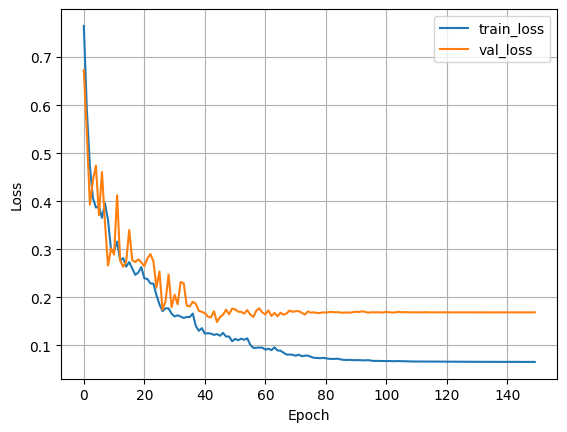

In [15]:
# Plot the loss

plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
#plt.ylim([0, 10])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

val_loss_per_epoch = history.history['val_loss']
train_loss_per_epoch = history.history['loss']
best_epoch = val_loss_per_epoch.index(min(val_loss_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

In [ ]:
""" # Re-instantiate the hypermodel and train it with the optimal number of epochs from above.

best_model = tuner.hypermodel.build(best_hps)

# Retrain the model
best_model.fit(train_features, train_labels, epochs=best_epoch, batch_size=batch_size, validation_split=0.1,callbacks=[reduce_lr], verbose=2) """

In [17]:
def plot_PredvsTrue(y_true, y_pred):

    plt.figure(figsize=(3, 3), dpi=200)
    p1 = min(y_true)
    p2 = max(y_true)
    #p1 = 0
    #p2 = 64
    #p1 = max(max(y_pred), max(y_true))
    #p2 = min(min(y_pred), min(y_true))
    plt.plot([p1, p2], [p1, p2], 'r--', label="Exact")
    plt.scatter(y_true,y_pred,color="blue",label="Model",s=6)
    plt.xlabel('True',fontsize=15)
    plt.ylabel('Pred',fontsize=15)
    plt.legend(loc="upper left")
    plt.show()

2/2 [==============================] - 0s 2ms/step
(50, 1)
(50, 1)


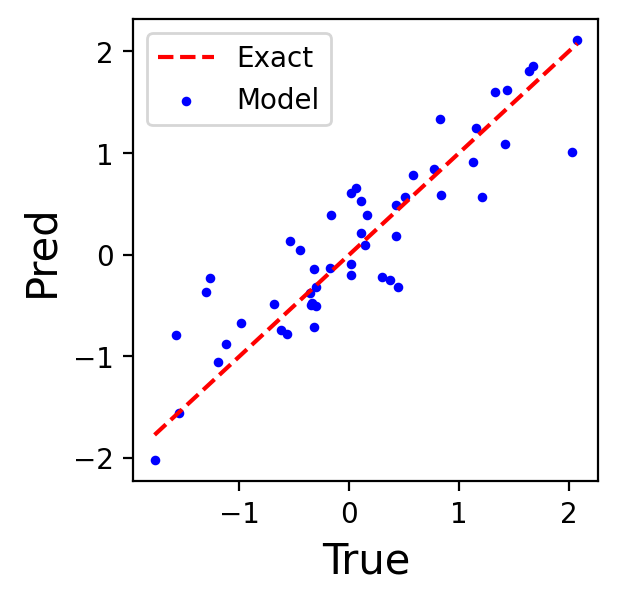

Test MAE: 0.317124792608926


In [18]:
# Pred vs True values on test set 

y_pred = model.predict(test_features)
y_pred.shape
y_true = np.zeros((len(test_ds['target']),1))
y_true[:,0] = test_ds['target']

print(y_true.shape)
print(y_pred.shape)
#print(y_true)
#print(y_pred)

plot_PredvsTrue(y_true, y_pred)

test_mae = mean_absolute_error(y_true,y_pred)
print("Test MAE: "+str(test_mae))

In [ ]:
""" # Pred vs True values on training set 

y_pred = model.predict(train_features)
y_pred.shape
y_true = np.zeros((len(train_ds['target']),1))
y_true[:,0] = train_ds['target']

print(y_true.shape)
print(y_pred.shape)
#print(y_true)
#print(y_pred)

plot_PredvsTrue(y_true, y_pred)

test_mae = mean_absolute_error(y_true,y_pred)
print("Train MAE: "+str(test_mae)) """

In [ ]:
""" # Evaluate the model with non-normalized units

y_true = y_true * R_std + R_mean
y_pred = y_pred * R_std + R_mean

#print("True: "+str(y_true))
#print("Pred: "+str(y_pred))

plot_PredvsTrue(y_true, y_pred)

test_mae = mean_absolute_error(y_true,y_pred)
print("Train MAE (non-normalized): "+str(test_mae)) """

In [139]:
# save model

#model.save('R_model_good_tiny')
#model.save('R_model_good_small')
#model.save('R_model_good_medium')
#model.save('R_model_good_large')
#reloaded_model = tf.keras.models.load_model('R_model')

7/7 [==============================] - 0s 934us/step


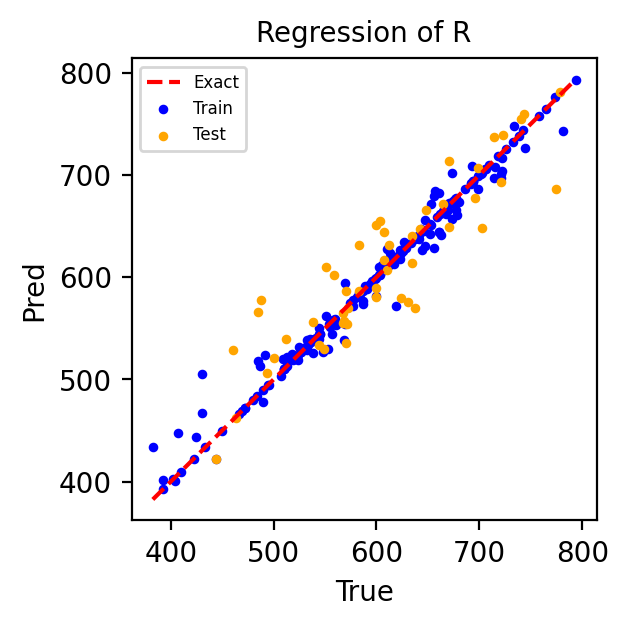

train MAE (non-normalized): 6.620664026921716
test MAE (non-normalized): 27.59107001562501


In [46]:
# Evaluate the model with non-normalized units on the whole dataset

y_pred_test = model.predict(test_features)
y_true_test = np.zeros((len(test_ds['target']),1))
y_true_test[:,0] = test_ds['target']

y_pred_train = model.predict(train_features)
y_true_train = np.zeros((len(train_ds['target']),1))
y_true_train[:,0] = train_ds['target']

#y_pred_val = model.predict(val_ds)
#y_true_val = np.zeros((len(val['target']),1))
#y_true_val[:,0] = val['target']

y_true_test = y_true_test * R_std + R_mean
y_pred_test = y_pred_test * R_std + R_mean
y_true_test = y_true_test.ravel()
y_pred_test = y_pred_test.ravel()

y_true_train = y_true_train * R_std + R_mean
y_pred_train = y_pred_train * R_std + R_mean
y_true_train = y_true_train.ravel()
y_pred_train = y_pred_train.ravel()

#y_true_val = y_true_val * R_std + R_mean
#y_pred_val = y_pred_val * R_std + R_mean
#y_true_val = y_true_val.ravel()
#y_pred_val = y_pred_val.ravel()

plt.figure(figsize=(3, 3), dpi=200)
plt.title("Regression of R",fontsize=10)
p1 = min(y_true_train)
p2 = max(y_true_train)
plt.plot([p1, p2], [p1, p2], 'r--', label="Exact")
plt.scatter(y_true_train,y_pred_train,color="blue",label="Train",s=6)
plt.scatter(y_true_test,y_pred_test,color="orange",label="Test",s=6)
#plt.scatter(y_true_val,y_pred_val,color="green",label="Val",s=6)
plt.xlabel('True',fontsize=10)
plt.ylabel('Pred',fontsize=10)
plt.legend(loc="upper left",prop={'size': 6})
plt.show()

train_mae = mean_absolute_error(y_true_train,y_pred_train)
print("train MAE (non-normalized): "+str(train_mae))
test_mae = mean_absolute_error(y_true_test,y_pred_test)
print("test MAE (non-normalized): "+str(test_mae))
#val_mae = mean_absolute_error(y_true_val,y_pred_val)
#print("val MAE (non-normalized): "+str(val_mae))

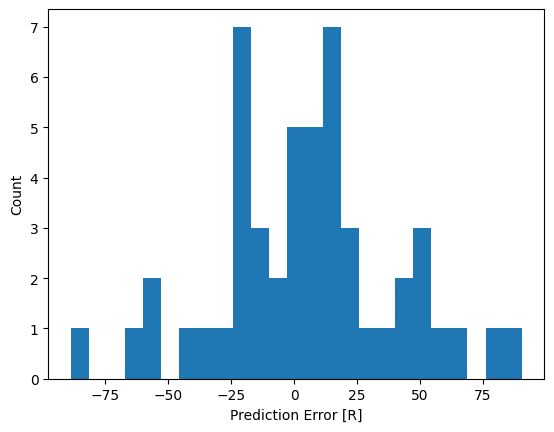

In [57]:
# Error distribution
error = y_pred_test - y_true_test
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [R]')
_ = plt.ylabel('Count')


[ 0.  9. 27.  4. 10.]
[        nan 15.48308863 32.13972    12.87484404 32.09338869]


/home/alfonso/Work/UGR/Calculations/Helicenes_NNs/Helicenes_venv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/alfonso/Work/UGR/Calculations/Helicenes_NNs/Helicenes_venv/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


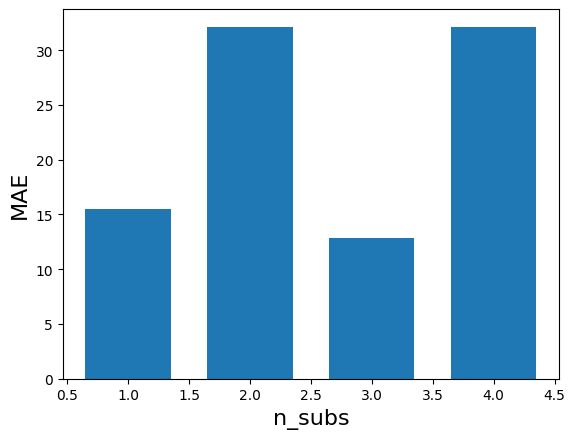

In [86]:
# Error for different nsubs

x_test = test_features.to_numpy()

nsubs_test = np.zeros( x_test.shape[0] )
nsubs_test = np.count_nonzero( x_test,axis=1 )
#print(x_test[0,:])
#print(nsubs_test)

nmax = 100
error0 = []
error1 = []
error2 = []
error3 = []
error4 = []
num_subs = np.zeros(5)
for i in range(len(nsubs_test)):
    error_i = y_pred_test[i] - y_true_test[i]
    if(nsubs_test[i]==0): 
        error0.append(error_i)
        num_subs[0] +=1
    if(nsubs_test[i]==1): 
        error1.append(error_i)
        num_subs[1] +=1
    if(nsubs_test[i]==2): 
        error2.append(error_i)
        num_subs[2] +=1
    if(nsubs_test[i]==3): 
        error3.append(error_i)
        num_subs[3] +=1
    if(nsubs_test[i]==4): 
        error4.append(error_i)
        num_subs[4] +=1

""" nbins = 50    
plt.hist(error0, bins=nbins, label='nsubs=0')
plt.hist(error1, bins=nbins, label='nsubs=1')
plt.hist(error2, bins=nbins, label='nsubs=2')
plt.hist(error3, bins=nbins, label='nsubs=3')
plt.hist(error4, bins=nbins, label='nsubs=4')
plt.legend()
plt.xlabel('Prediction Error [R]')
_ = plt.ylabel('Count')
plt.show() """

error_nsubs = np.zeros(5)
error_nsubs[0] = np.mean(np.abs(error0))
error_nsubs[1] = np.mean(np.abs(error1))
error_nsubs[2] = np.mean(np.abs(error2))
error_nsubs[3] = np.mean(np.abs(error3))
error_nsubs[4] = np.mean(np.abs(error4))

print(num_subs)
print(error_nsubs)

bin_edges = np.arange(1.5,4.5+1,1)
plt.bar([0,1,2,3,4],error_nsubs[0:], width=0.7)
plt.xlabel("n_subs",fontsize=16)
plt.ylabel("MAE",fontsize=16)
plt.show()
